In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import wdtools
import WD_models
import data_selector as ds
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

2022-08-04 12:53:04.265366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 12:53:04.265442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Please install galpy if you want to use the gaia module. otherwise, ignore this.


In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
bsq = BayestarQuery()
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 77.866 s
  pix_info:   1.410 s
   samples:  30.423 s
      best:  33.268 s
       nan:   6.761 s
      sort:   5.692 s
       idx:   0.312 s
E(B-V) = 0.050 mag


In [4]:
catalog = Table.read('/home/arseneausm/Downloads/sed_radii.fits')
for key in catalog.keys():
    print(key)

dist
solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_g_mean_mag
phot_bp_n_obs
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_bp_me

(PAPER TO UPDATE THIS LATER)[https://iopscience.iop.org/article/10.1088/0004-637X/737/2/103#apj398709t6]

In [5]:
catalog = catalog[catalog['parallax'] > 0]
coords = [SkyCoord(frame="galactic", l=catalog['l'][i]*u.deg, b=catalog['b'][i]*u.deg, distance = (1000/catalog['parallax'][i]) * u.kpc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

In [6]:
catalog['E(B-V)'] = [bsq.query(catalog['wd_coords'][i]) for i in range(len(catalog))]

In [7]:
catalog['err_u'] = catalog['su']
catalog['err_g'] = catalog['sg']
catalog['err_r'] = catalog['sr']
catalog['err_i'] = catalog['si']
catalog['err_z'] = catalog['sz']

In [8]:
catalog['A_u'] = np.repeat(np.nan, len(catalog))
catalog['A_g'] = np.repeat(np.nan, len(catalog))
catalog['A_r'] = np.repeat(np.nan, len(catalog))
catalog['A_i'] = np.repeat(np.nan, len(catalog))
catalog['A_z'] = np.repeat(np.nan, len(catalog))

for obj in tqdm(catalog):
    obj['A_u'] = obj['E(B-V)'] * 3.518
    obj['A_g'] = obj['E(B-V)'] * 2.617
    obj['A_r'] = obj['E(B-V)'] * 1.971
    obj['A_i'] = obj['E(B-V)'] * 1.549
    obj['A_z'] = obj['E(B-V)'] * 1.263
    
catalog['dered_u'] = catalog['u'] - catalog['A_u']
catalog['dered_g'] = catalog['g'] - catalog['A_g']
catalog['dered_r'] = catalog['r'] - catalog['A_r']
catalog['dered_i'] = catalog['i'] - catalog['A_i']
catalog['dered_z'] = catalog['z'] - catalog['A_z']

catalog['r_est'] = 1000 / catalog['parallax']

100%|████████████████████████████████████████████████████████████████████| 7168/7168 [00:00<00:00, 25654.88it/s]


In [9]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']


In [10]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 
    
def get_model_flux(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux
    

def residual(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [11]:
def get_parameters(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):      
    obs_flux = mag_to_flux(obs_mag)
    #obs_flux = obs_mag
    
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    e_obs_flux = e_obs_mag * obs_flux
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
    
    #result.params.pretty_print()
    
    if make_plot:
        bands = ['u', 'g', 'r', 'i', 'z']
        
        
        
        fig = plt.figure(figsize = (8,7))
        plt.errorbar(bands, obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED')
        plt.plot(bands, get_model_flux(result.params), 'bo', markersize = 10, label = 'Model SED')
        plt.title('SED {}'.format(id_))
        plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(result.params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
        plt.xlabel('Band')
        plt.ylabel('Apparent Flux)')
        #plt.gca().invert_yaxis()
        plt.legend() 
        
        return result, fig
    
    return result

In [12]:
results = []
results7 = []
results9 = []
e_results = []

plots = []

logg_vary = []

for i in tqdm(range(len(catalog))):
    obs_mag = np.array([catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i], catalog['i'][i] + 0.015, catalog['z'][i] + 0.030])
    e_obs_mag = np.array([catalog['err_u'][i], catalog['err_g'][i], catalog['err_r'][i], catalog['err_i'][i], catalog['err_z'][i]])
    
    logg7 = get_parameters(obs_mag, e_obs_mag, id_ = 0, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    logg8 = get_parameters(obs_mag, e_obs_mag, id_ = 0, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]], make_plot = False )
    logg9 = get_parameters(obs_mag, e_obs_mag, id_ = 0, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #plots.append(plot)
    
    results.append(logg8)
    results7.append(logg7)
    results9.append(logg9)
    logg_vary.append(get_parameters(obs_mag, e_obs_mag, vary_logg = True, p0 = [10000, 8, 0.01, catalog['r_est'][i]]))

100%|███████████████████████████████████████████████████████████████████████| 7168/7168 [08:14<00:00, 14.50it/s]


In [13]:
vary_catalog = catalog.copy()

catalog['radius2'] = [result.params['radius'].value for result in results]
catalog['phot_teff'] = [result.params['teff'].value for result in results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in results]
catalog['redchi'] = [result.redchi for result in results]
catalog['e_radius'] = [np.sqrt(results[i].params['radius'].stderr**2 + np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value)**2 ) for i in range(len(results))]
catalog['error_from_model'] = [np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value) for i in range(len(results))]

vary_catalog['radius'] = [result.params['radius'].value for result in logg_vary]
vary_catalog['teff'] = [result.params['teff'].value for result in logg_vary]
vary_catalog['e_teff'] = [result.params['teff'].stderr for result in logg_vary]
vary_catalog['redchi'] = [result.redchi for result in logg_vary]
vary_catalog['e_radius'] = [result.params['radius'].stderr for result in logg_vary]

Text(0.5, 0, 'Photometric Radius $[R_{0}]$')

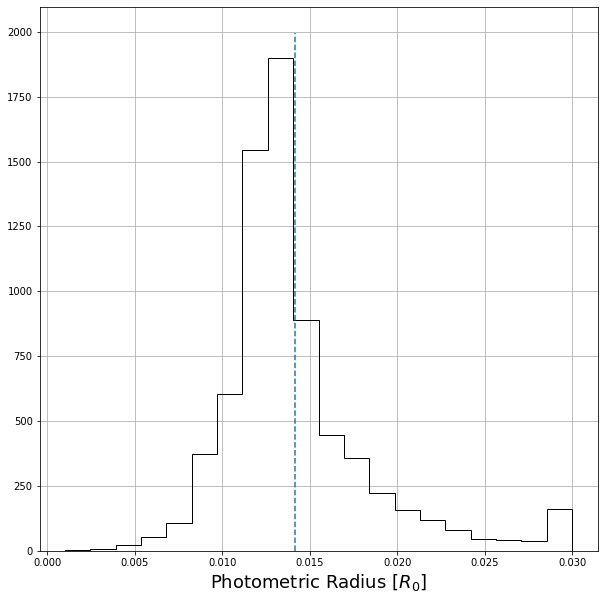

In [14]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)


Checking radii by plotting scatterplots-- join on gaia source id's

Go ahead and make a CMD of the sample. If we hace 

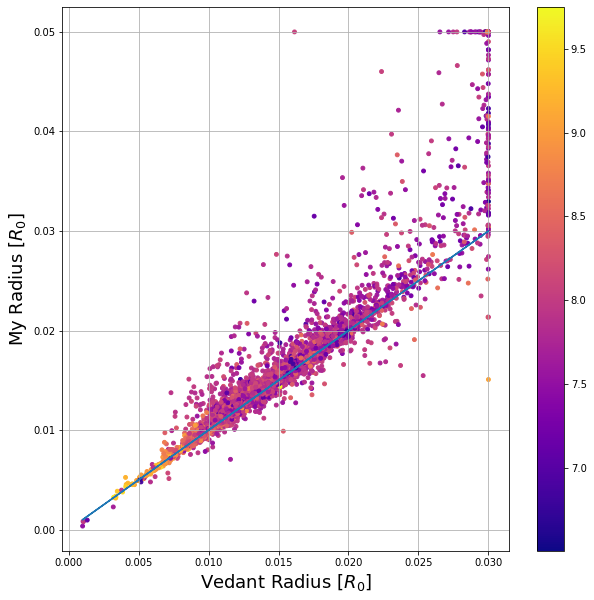

In [15]:
import scipy.stats as stats

def linear(x):
    return x

temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.grid()
plt.scatter(temp_catalog['radius'], temp_catalog['radius2'], c = temp_catalog['logg'], s=15, cmap='plasma')
plt.plot(temp_catalog['radius'], linear(temp_catalog['radius']))
ymin, ymax = plt.ylim()
plt.xlabel(r'Vedant Radius $[R_{0}]$', fontsize=18)
plt.ylabel(r'My Radius $[R_{0}]$', fontsize=18)
plt.colorbar()